# Quick Start

In this section, we are going to generate some synthetic multivariate time series data, inject some anomalies into test data. And then use some Machine learning techniques to detect these anomalies.

In [47]:
import pandas as pd
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10), dpi=200)

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

## 1. Data Generation 

Numalogic provides a synthetic time series data generator, that can be used to experiment and evaluate different ML alogorithms. Here we are generaing 3 timeseries (num_series) with 8000 data points (seq_len).

For more details on synthetic data generation, please refer to [data generator](../docs/data-generator.md)

In [48]:
from numalogic.synthetic import SyntheticTSGenerator

ts_generator = SyntheticTSGenerator(
    seq_len=8000,
    num_series=3,
    freq="T",
    primary_period=720,
    secondary_period=6000,
    seasonal_ts_prob=0.8,
    baseline_range=(200.0, 350.0),
    slope_range=(-0.001, 0.01),
    amplitude_range=(10, 75),
    cosine_ratio_range=(0.5, 0.9),
    noise_range=(5, 15),
)

# shape: (8000, 1) with column names [s1]
ts_df = ts_generator.gen_tseries()  

<AxesSubplot: title={'center': 'Time series data'}>

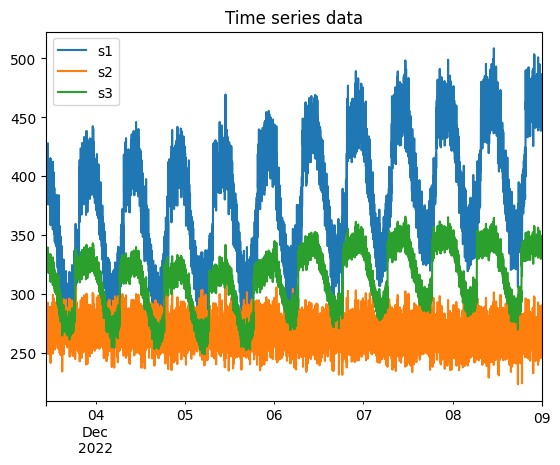

In [49]:
ts_df.plot(title="Time series data")

Now, we split the generated data into train and test dataframes, with test set size 1000 leaving 7000 datapoints for training.

In [50]:
train_df, test_df = ts_generator.train_test_split(ts_df, test_size=1000)

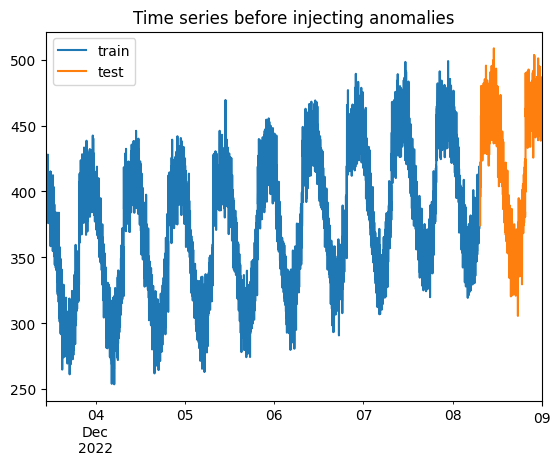

In [51]:
ax = train_df["s1"].plot(label="train")
test_df["s1"].plot(ax=ax, label="test", title="Time series before injecting anomalies")
plt.legend()

## 2. Inject anomalies:

Now, we inject anomalies into the test set using the `AnomalyGenerator`. Here we are adding `contextual` anomalies, you could also try `causal` or `collective` anomalies.

In [52]:
from numalogic.synthetic import AnomalyGenerator

injected_cols = ["s1", "s2"]  # columns to inject anomalies
anomaly_generator = AnomalyGenerator(train_df, anomaly_type="contextual", anomaly_ratio=0.3)
outliers_test_df = anomaly_generator.inject_anomalies(
    test_df, cols=injected_cols, impact=1.5
)

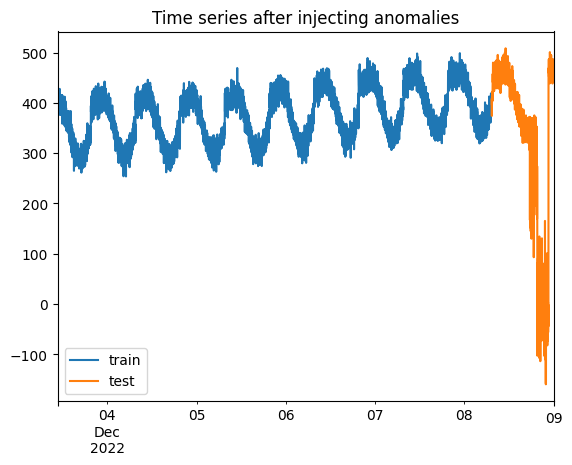

In [53]:
ax = train_df["s1"].plot(label="train")
outliers_test_df["s1"].plot(ax=ax, label="test", title="Time series after injecting anomalies")
plt.legend()

## 3. Pre-Processing:

Pre-processing is an optional step, where we can clean, scale or transform the data. We can transform the features by scaling each feature to a given range, while keeping the shape of the distribution same. 

Here we are using `MinMaxScaler`, you could also try other scalers like `StandarScaler` or `RobustScaler`.

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df.to_numpy())
X_test = scaler.transform(outliers_test_df.to_numpy())

## 4. Threshold Estimator:

In here, we define the threshold estimator and fit it using the training data set.

In [55]:
from numalogic.models.threshold._std import StdDevThreshold

thresh_clf = StdDevThreshold(std_factor=3)
thresh_clf.fit(X_train.reshape(-1, 1))

StdDevThreshold(std_factor=3)

## 5. Training:

In the training step, we define the model and train it on the training data set. `SparseAEPipeline` is a sparse autoencoder trainer that follows sklearn's API pattern. 

In [56]:
from numalogic.models.autoencoder import SparseAEPipeline
from numalogic.models.autoencoder.variants import Conv1dAE

pipeline = SparseAEPipeline(
    model=Conv1dAE(in_channels=3, enc_channels=8), seq_len=36, num_epochs=30
)
pipeline.fit(X_train)

2022-12-09 18:23:23,247 - INFO - Training sparse autoencoder model with beta: 0.001, and rho: 0.05
2022-12-09 18:23:23,248 - INFO - Using kl_div regularized loss
2022-12-09 18:23:24,959 - INFO - epoch : 5, penalty: 0.0014599192654713988 loss_mean : 0.0435277
2022-12-09 18:23:26,194 - INFO - epoch : 10, penalty: 0.0014999237610027194 loss_mean : 0.0194861
2022-12-09 18:23:27,491 - INFO - epoch : 15, penalty: 0.0013811790850013494 loss_mean : 0.0139388
2022-12-09 18:23:28,596 - INFO - epoch : 20, penalty: 0.001234247232787311 loss_mean : 0.0116860
2022-12-09 18:23:30,303 - INFO - epoch : 25, penalty: 0.0010954368626698852 loss_mean : 0.0103516
2022-12-09 18:23:31,807 - INFO - epoch : 30, penalty: 0.0009711519232951105 loss_mean : 0.0094082


## 6. Inference:

Now, we use the trained model from above to predict anomalies in the test data. The predict method return the reconstruction error produced by the model. 

Score method returns the anomaly score, calculated using thresholds. If the score is less than 1, it indicates an inlier. And the score greater than 1 indicates an outlier or anomaly.

In [57]:
test_recon = pipeline.predict(X_test)
test_anomaly_score = pipeline.score(X_test)
test_anomaly_score = thresh_clf.predict(test_anomaly_score)
test_anomaly_score

array([[0.03953706, 0.02283082, 0.14682023],
       [0.11847361, 0.2631961 , 0.04124341],
       [0.01379496, 0.0057159 , 0.09038273],
       ...,
       [0.11696532, 0.20304612, 0.05622444],
       [0.19488005, 0.0442475 , 0.1566194 ],
       [0.21542044, 0.0984635 , 0.17402739]])

In [58]:
anomalies_df = pd.DataFrame(data=test_anomaly_score, columns=outliers_test_df.columns, index=outliers_test_df.index)

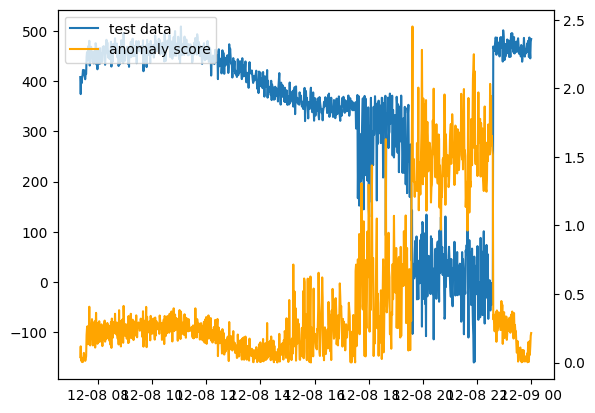

In [59]:
ax1 = plt.subplot()
l1, = ax1.plot(outliers_test_df["s1"])
ax2 = ax1.twinx()
l2, = ax2.plot(anomalies_df["s1"], color="orange")
plt.legend([l1, l2], ["test data", "anomaly score"])
plt.show()

## 7. Post-processing:

Post-processing step is again an optional step, where we normalize the anomalies between 0-10.


In [60]:
from numalogic.postprocess import tanh_norm

test_anomaly_score_norm = tanh_norm(test_anomaly_score)

In [61]:
norm_anomalies_df = pd.DataFrame(data=test_anomaly_score_norm, columns=outliers_test_df.columns, index=outliers_test_df.index)

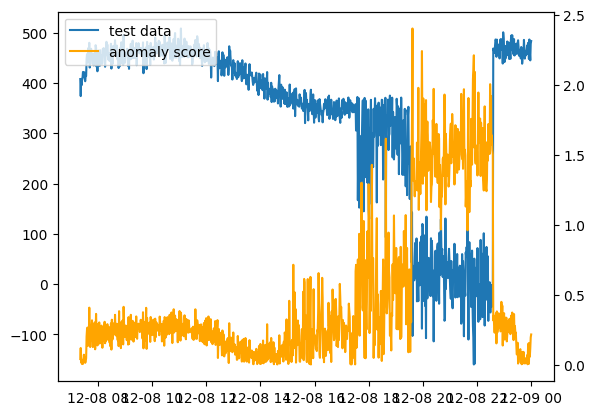

In [62]:
ax1 = plt.subplot()
l1, = ax1.plot(outliers_test_df["s1"])
ax2 = ax1.twinx()
l2, = ax2.plot(norm_anomalies_df["s1"], color="orange")
plt.legend([l1, l2], ["test data", "anomaly score"])
plt.show()